# **Example**

In [0]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Using TensorFlow backend.


**y = mx + b + noise**

In [0]:
m = 2
b = 3
x = np.linspace(0, 50, 100)

In [0]:
np.random.seed(101)
noise = np.random.normal(loc=0, scale=4, size=len(x))

In [0]:
y = m*x + b + noise

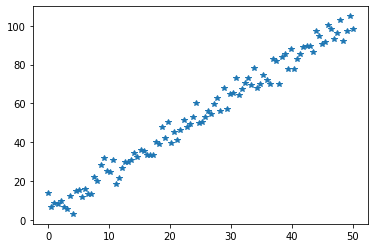

In [0]:
plt.plot(x,y,'*')

In [0]:
from keras.models import Sequential
from keras.layers import Dense

In [0]:
model = Sequential()
model.add(Dense(4,input_dim=1,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mse',optimizer='adam')

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 8         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(x,y,epochs=300)

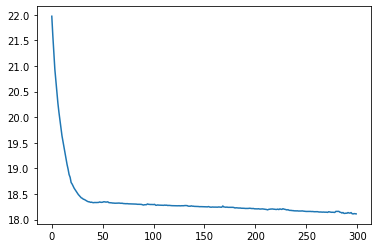

In [0]:
loss = model.history.history['loss']
epochs = range(len(loss))
plt.plot(epochs,loss)

In [0]:
x_for_prediction = np.linspace(0,50,100)
y_predicted = model.predict(x_for_prediction)

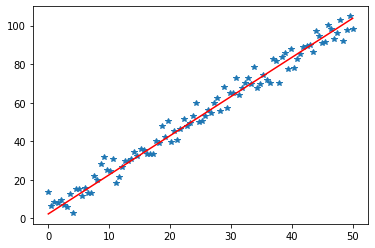

In [0]:
plt.plot(x,y,'*')
plt.plot(x_for_prediction,y_predicted,'r')

In [0]:
from sklearn.metrics import mean_squared_error

In [0]:
mean_squared_error(y,y_predicted)

18.111946330296878

# **TS FORECASTING**

In [0]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [0]:
df = pd.read_csv('/content/drive/My Drive/Time Series practise/Data/Alcohol_Sales.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'

In [24]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [0]:
df.columns = ['Sales']

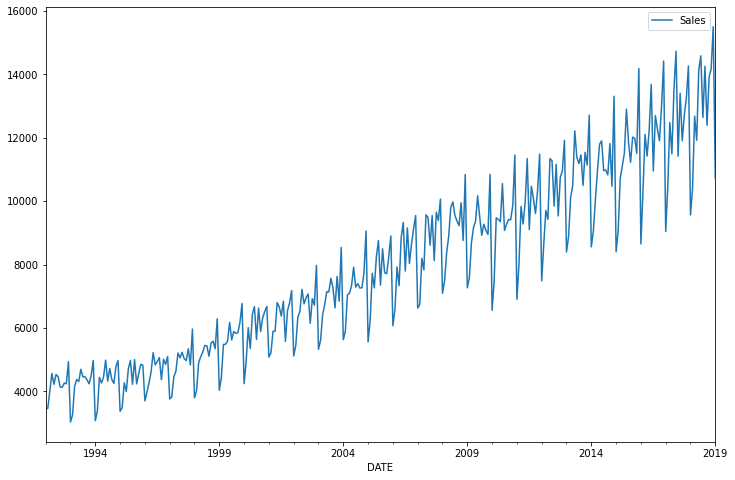

In [26]:
df.plot(figsize=(12,8))

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [0]:
results = seasonal_decompose(df['Sales'])

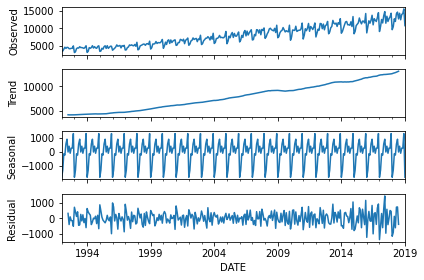

In [29]:
results.plot();

In [0]:
train_data = df.iloc[:313]
test_data = df.iloc[313:]

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
scaler = MinMaxScaler()
scaler.fit(train_data)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

**using time series generator**

In [0]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [0]:
n_input = 12
n_features = 1
train_generator = TimeseriesGenerator(scaled_train_data,scaled_train_data,length=n_input,batch_size=1)

**creating the model**

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [0]:
model = Sequential()
model.add(LSTM(150,activation='relu',input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit_generator(train_generator, epochs=50)

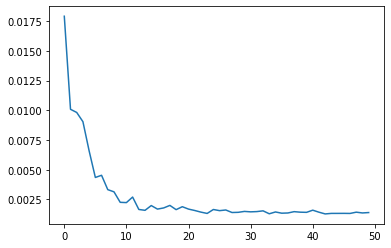

In [42]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

**evaluate on test data**

In [0]:
first_eval_batch = scaled_train_data[-12:]
first_eval_batch = first_eval_batch.reshape((1,n_input,n_features))

In [45]:
model.predict(first_eval_batch)

array([[0.71719325]], dtype=float32)

In [47]:
scaled_test_data[0]

array([0.63116506])

In [0]:
test_predictions = []
first_eval_batch = scaled_train_data[-n_input:]
current_batch = first_eval_batch.reshape((1,n_input,n_features))

In [49]:
current_batch.shape

(1, 12, 1)

In [0]:
for i in range(len(test_data)):
	current_pred = model.predict(current_batch)[0]
	test_predictions.append(current_pred)
	current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

**inverse transformation and compare**

In [0]:
true_predictions = scaler.inverse_transform(test_predictions)

In [0]:
test_data['Predictions'] = true_predictions

In [54]:
test_data

,Sales,Predictions
DATE,,
2018-02-01,10415,11421.443784
2018-03-01,12683,12475.034056
2018-04-01,11919,12328.654443
2018-05-01,14138,14119.312671
2018-06-01,14583,14912.368724
2018-07-01,12640,12080.325324
2018-08-01,14257,13687.322006
2018-09-01,12396,12259.415971
2018-10-01,13914,13299.649877


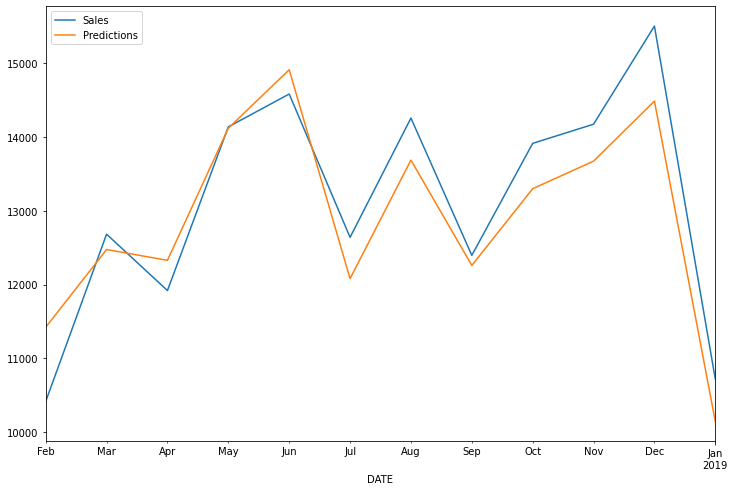

In [56]:
test_data.plot(figsize=(12,8))